In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pymongo import MongoClient
import os

# Connect to MongoDB
client = MongoClient('mongodb://localhost:27017/')
db = client['breast_cancer_wisconsin']
collection = db['cleaned_data']

# Retrieve data from MongoDB
df = pd.DataFrame(list(collection.find()))

# Map 'diagnosis' to 'Benign' and 'Malignant'
df['diagnosis'] = df['diagnosis'].map({'B': 'Benign', 'M': 'Malignant'})

In [2]:
# Creating Files for Images
output_folder_boxplots = './img/boxplots'
os.makedirs(output_folder_boxplots, exist_ok=True)

output_folder_pairplots = './img/pairplots'
os.makedirs(output_folder_pairplots, exist_ok=True)

output_folder_densityplots = './img/densityplots'
os.makedirs(output_folder_densityplots, exist_ok=True)

output_folder_distributionplots = './img/correlationplots'
os.makedirs(output_folder_distributionplots, exist_ok=True)

output_folder_probabilityplots = './img/probabilityplots'
os.makedirs(output_folder_probabilityplots, exist_ok=True)

output_folder_correlationplots = './img/correlationplots'
os.makedirs(output_folder_correlationplots, exist_ok=True)

In [3]:
#Defining color mapping for 'Benign' and 'Malignant' (because we like pretty things :) ) 
color_map = {'Benign': 'darkturquoise', 'Malignant': 'darkred'}

#Defining the four main metric groups for cleaner visualisation
size_metrics = ['radius_mean', 'area_mean', 'perimeter_mean']
shape_metrics = ['concavity_mean', 'concave points_mean', 'smoothness_mean']
texture_metrics = ['texture_mean', 'texture_worst']
compactness_metrics = ['compactness_mean', 'compactness_worst']

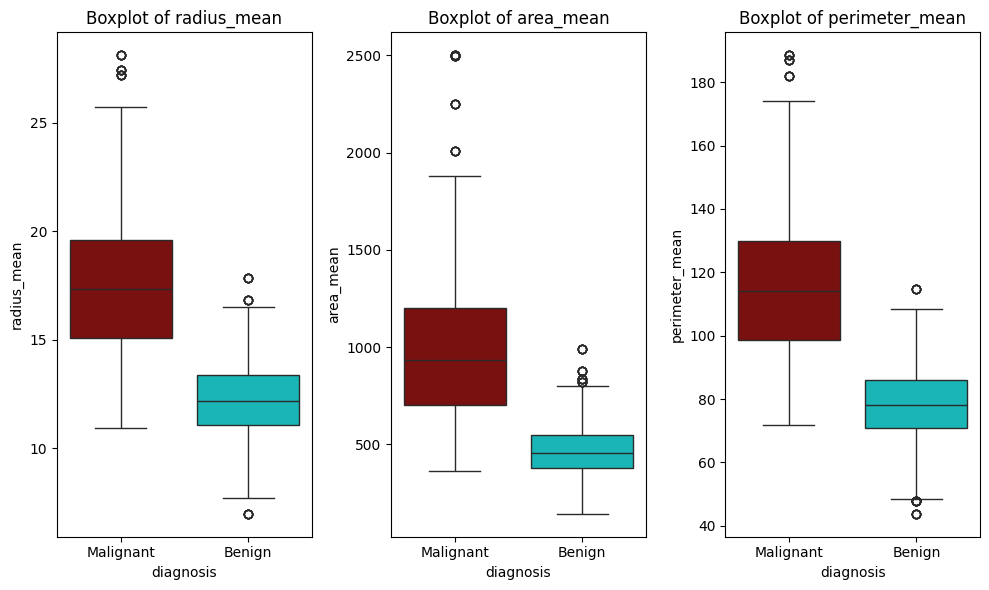

In [4]:
#Size: Boxplots
plt.figure(figsize=(10, 6))
for i, metric in enumerate(size_metrics, 1):
    plt.subplot(1, len(size_metrics), i)
    sns.boxplot(x='diagnosis', y=metric, data=df, 
                hue='diagnosis', 
                dodge=False,  
                palette=color_map)
    plt.title(f"Boxplot of {metric}")
    plt.xlabel("diagnosis")
    plt.ylabel(metric)
plt.tight_layout()

plot_path = os.path.join(output_folder_boxplots, 'Boxplot_size_metrics.png')
plt.savefig(plot_path)

plt.show()

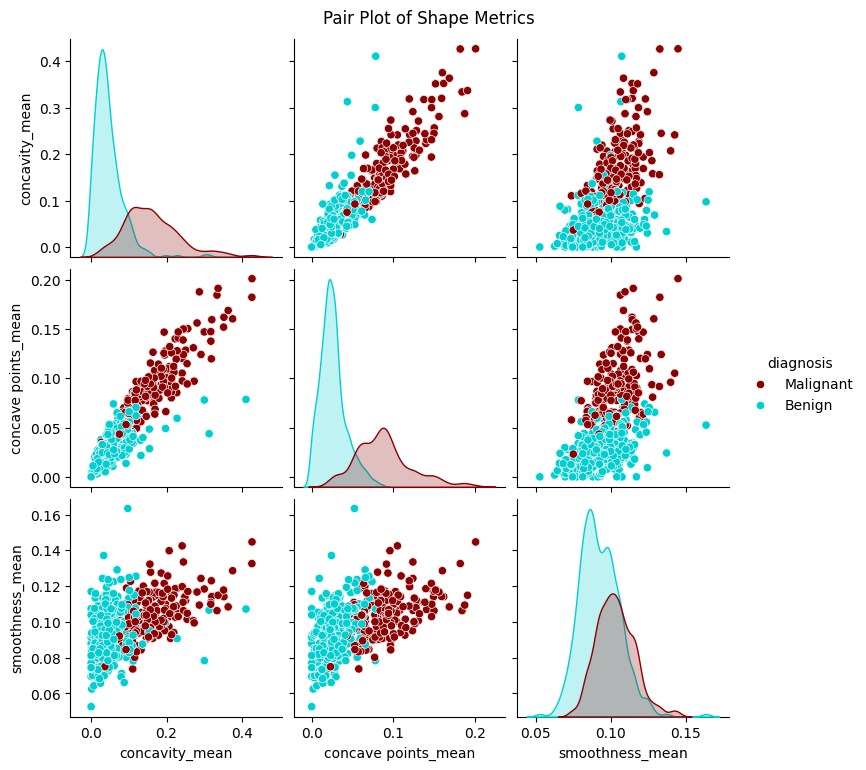

In [5]:
#Shape: Pair Plots 
sns.pairplot(
    df[shape_metrics + ['diagnosis']],
    hue='diagnosis', 
    diag_kind='kde', 
    palette=color_map  
)
plt.suptitle("Pair Plot of Shape Metrics", y=1.02)

plot_path = os.path.join(output_folder_pairplots, 'Pairplots_shape_metrics.png')
plt.savefig(plot_path)

plt.show()

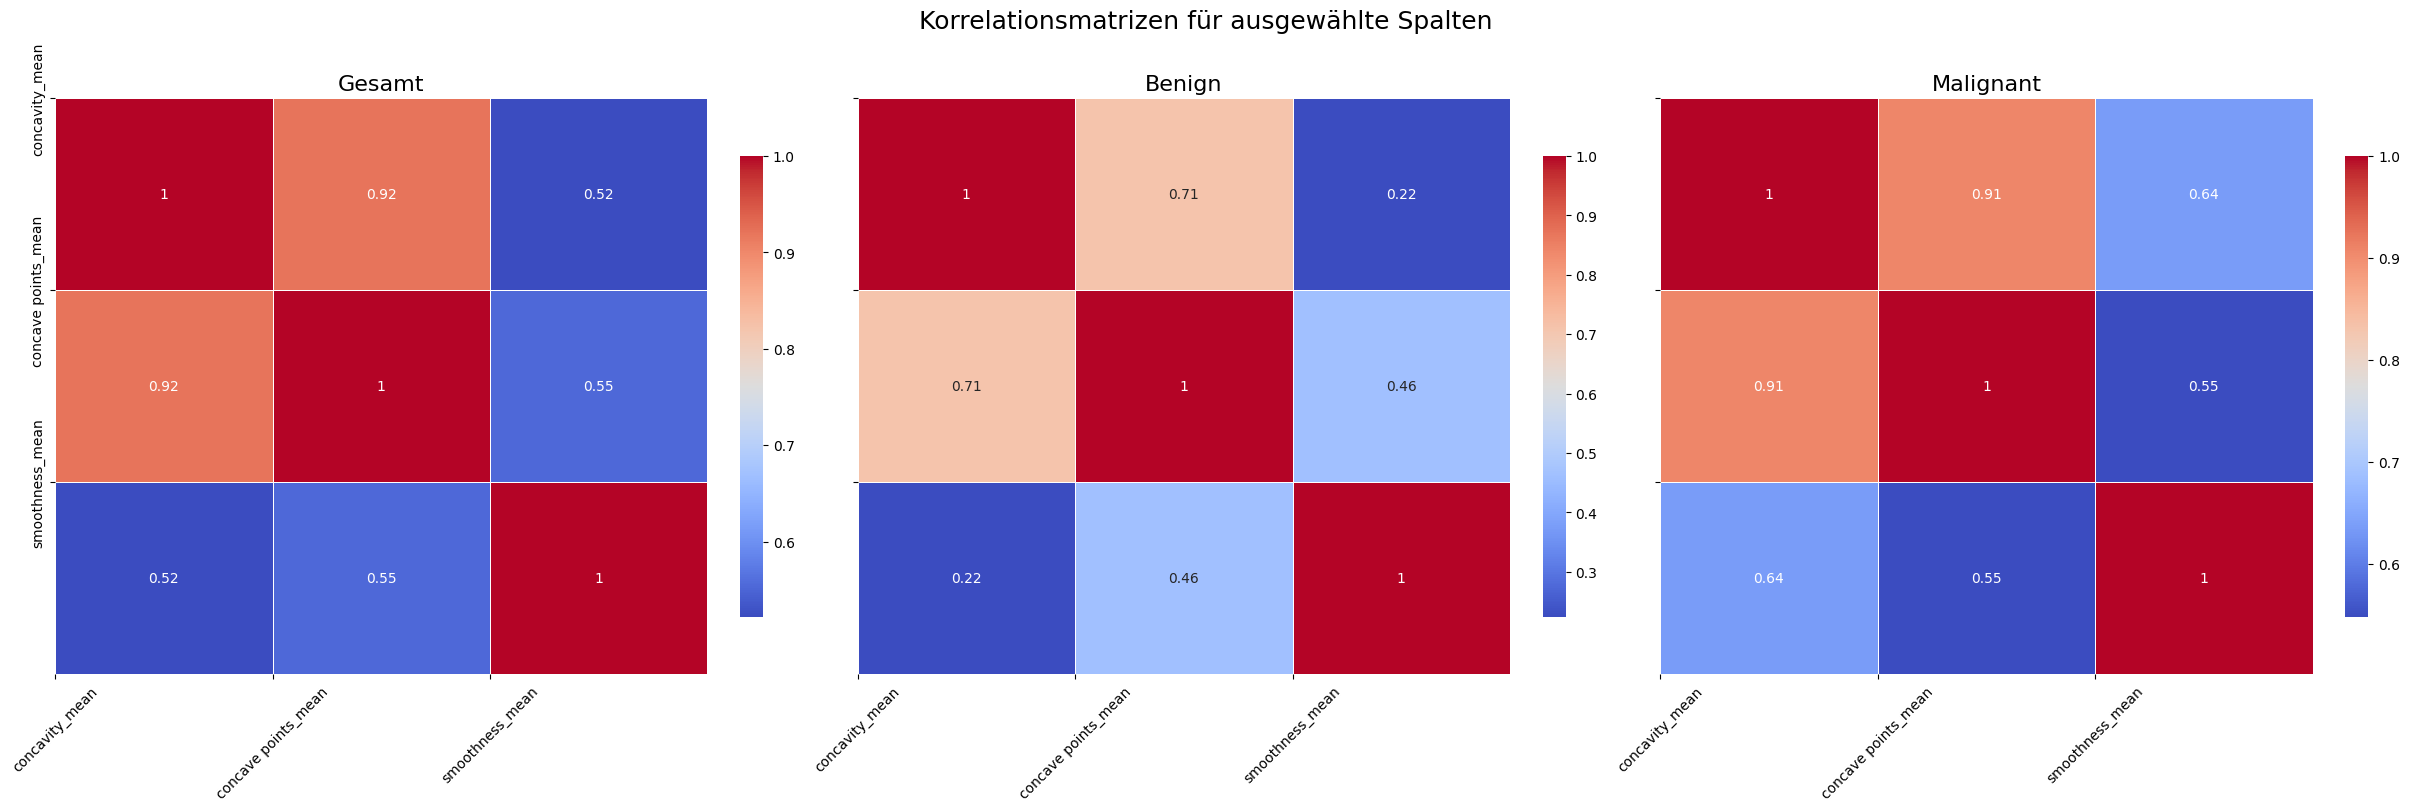

In [6]:
# Creating Correlation-Plots
def get_correlation_matrix(data, columns):
    numerische_spalten = data[columns]
    return numerische_spalten.corr(method='pearson')

def plot_heatmap(ax, correlation_matrix, title, shape_metrics, show_y_labels=True):
    sns.heatmap(
        correlation_matrix, 
        annot=True, 
        cmap='coolwarm', 
        ax=ax, 
        cbar_kws={"shrink": 0.8},
        annot_kws={"size": 10}, 
        linewidths=0.5
    )
    ax.set_title(title, fontsize=16)
    ax.set_xticks(range(len(shape_metrics)))
    ax.set_yticks(range(len(shape_metrics)))
    ax.set_xticklabels(shape_metrics, fontsize=10, rotation=45)
    if show_y_labels:
        ax.set_yticklabels(shape_metrics, fontsize=10)
    else:
        ax.set_yticklabels([])

correlation_full = get_correlation_matrix(df, shape_metrics)
correlation_benign = get_correlation_matrix(df[df['diagnosis'] == 'Benign'], shape_metrics)
correlation_malignant = get_correlation_matrix(df[df['diagnosis'] == 'Malignant'], shape_metrics)

fig, axes = plt.subplots(1, 3, figsize=(24, 8), constrained_layout=True)

plot_heatmap(axes[0], correlation_full, 'Gesamt', shape_metrics, show_y_labels=True)
plot_heatmap(axes[1], correlation_benign, 'Benign', shape_metrics, show_y_labels=False)
plot_heatmap(axes[2], correlation_malignant, 'Malignant', shape_metrics, show_y_labels=False)

plt.suptitle('Korrelationsmatrizen für ausgewählte Spalten', fontsize=18)

plot_path = os.path.join(output_folder_correlationplots, 'korrelationsplots_shape_metrics.png')
plt.savefig(plot_path)

plt.show()

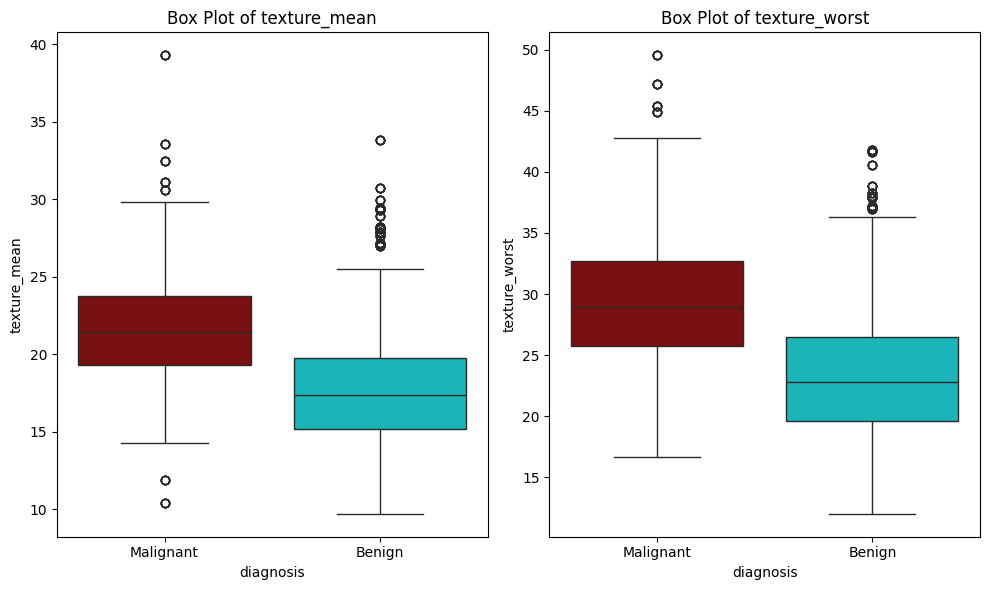

In [7]:
#Texture: Box Plots 
plt.figure(figsize=(10, 6))
for i, metric in enumerate(texture_metrics, 1):
    plt.subplot(1, len(texture_metrics), i)
    sns.boxplot(x='diagnosis', y=metric, data=df, 
                hue='diagnosis', 
                dodge=False,  
                palette=color_map)
    plt.title(f"Box Plot of {metric}")
    plt.xlabel("diagnosis")
    plt.ylabel(metric)
plt.tight_layout()

plot_path = os.path.join(output_folder_boxplots, 'Boxplot_texture_metrics.png')
plt.savefig(plot_path)

plt.show()

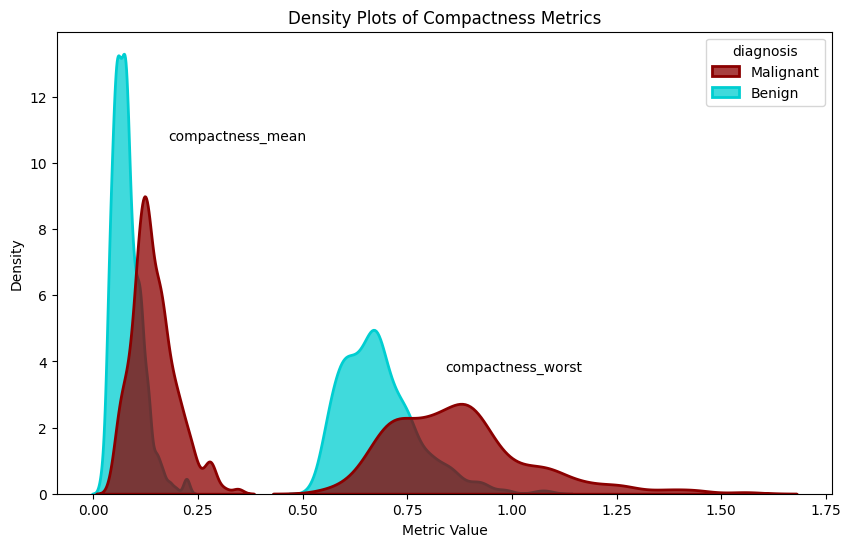

In [8]:
# Compactness: Density Plot with Brute-Forced Labels
plt.figure(figsize=(10, 6))

# Define fixed y and x offsets for each metric label
label_offsets = {
    'compactness_mean': (10.7, 0.24),  # (y_offset, x_offset)
    'compactness_worst': (3.7, 0.25)
}

for i, metric in enumerate(compactness_metrics):
    # Shift the x-axis values slightly for each metric to avoid overlap
    shift = i * 0.5  # Adjust this value to control the distance between plots

    # Plot density curve
    sns.kdeplot(
        data=df,
        x=df[metric] + shift,  # Apply the shift
        hue='diagnosis',
        fill=True,
        common_norm=False,
        alpha=0.75,
        palette=color_map,
        linewidth=2
    )


    # Add label at fixed positions
    y_offset, x_offset = label_offsets[metric]
    plt.text(
        df[metric].mean() + shift + x_offset,
        y_offset,
        metric,
        horizontalalignment='center',
        fontsize=10,
        color='black'
    )


plot_path = os.path.join(output_folder_densityplots, 'Densityplot_compactness_metrics.png')
plt.savefig(plot_path)

plt.title("Density Plots of Compactness Metrics")
plt.xlabel("Metric Value")
plt.ylabel("Density")

plot_path = os.path.join(output_folder_densityplots, 'Densityplot_compactness_metrics.png')
plt.savefig(plot_path)

plt.show()

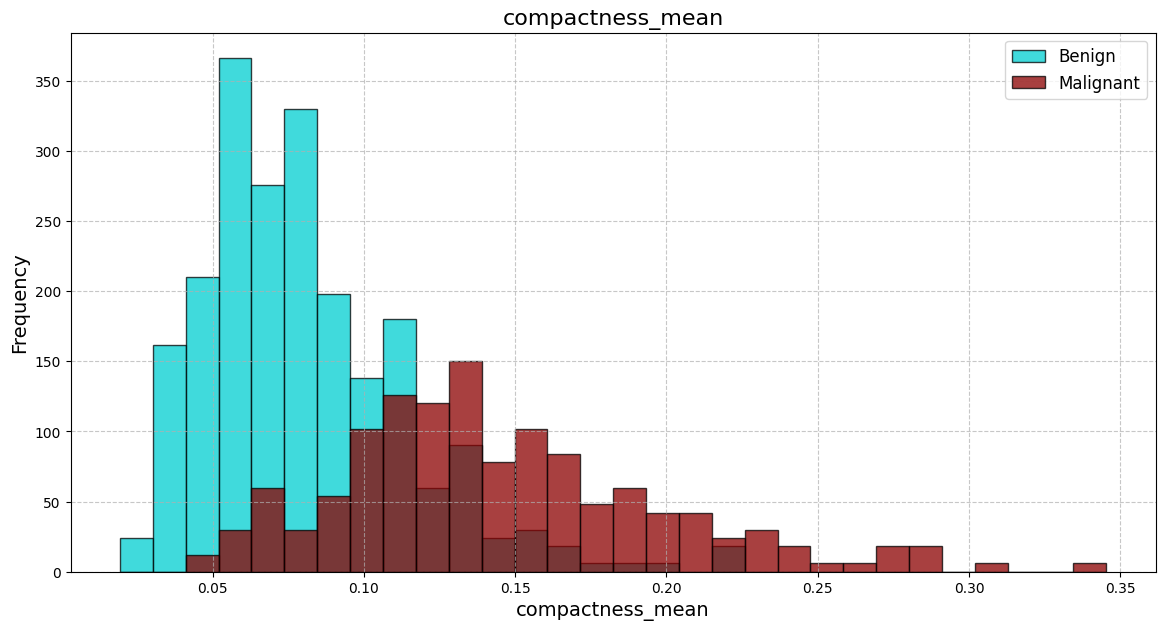

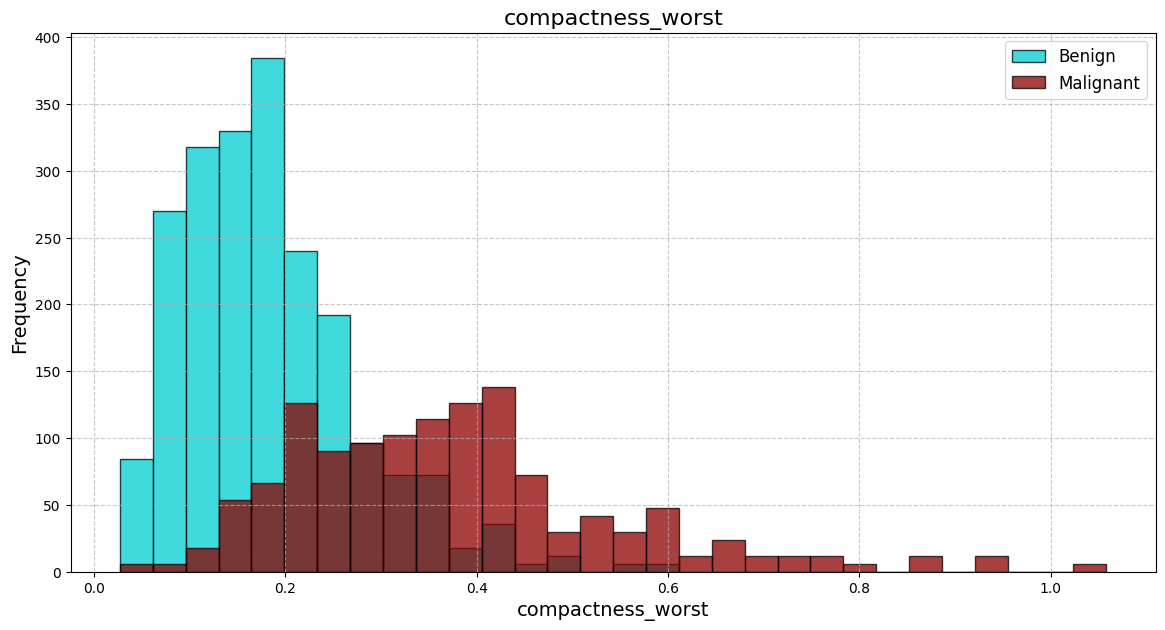

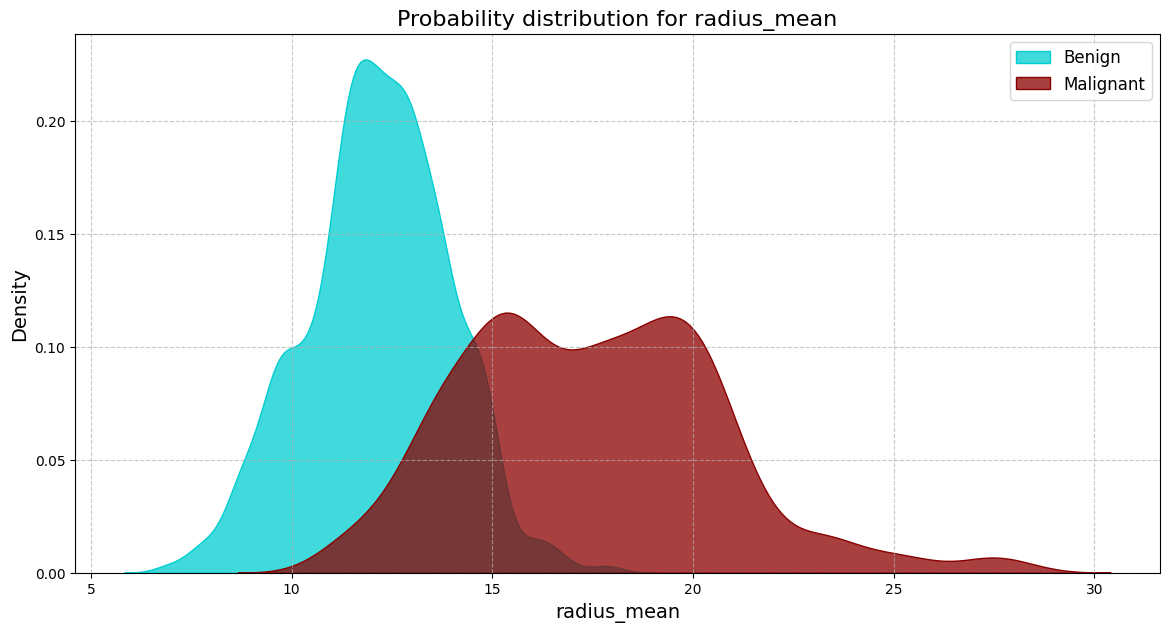

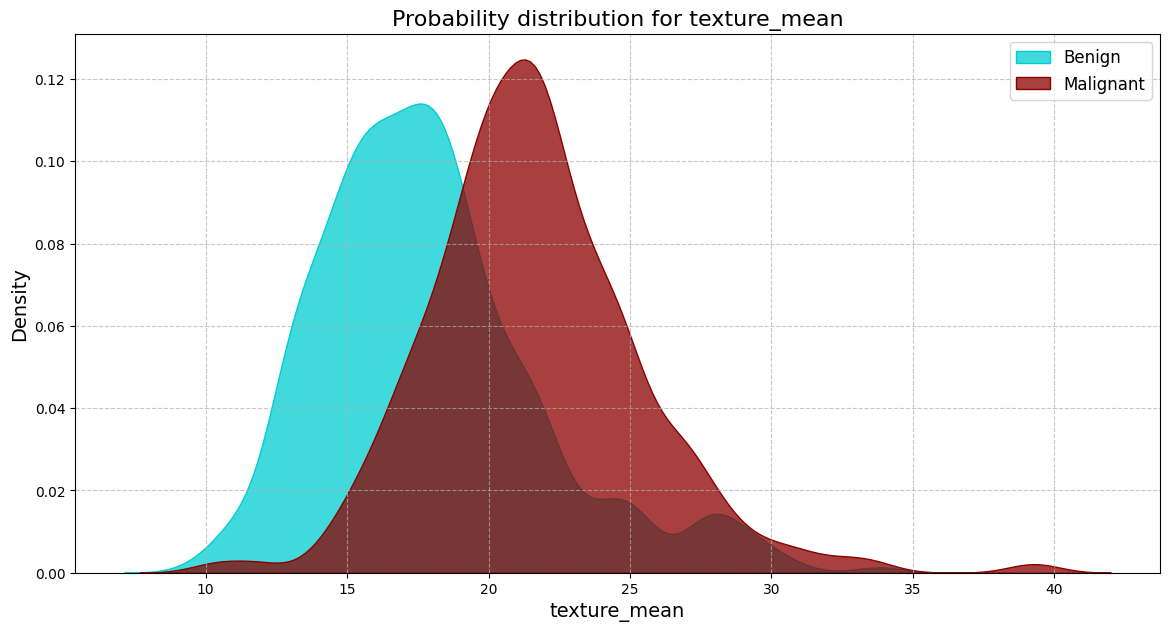

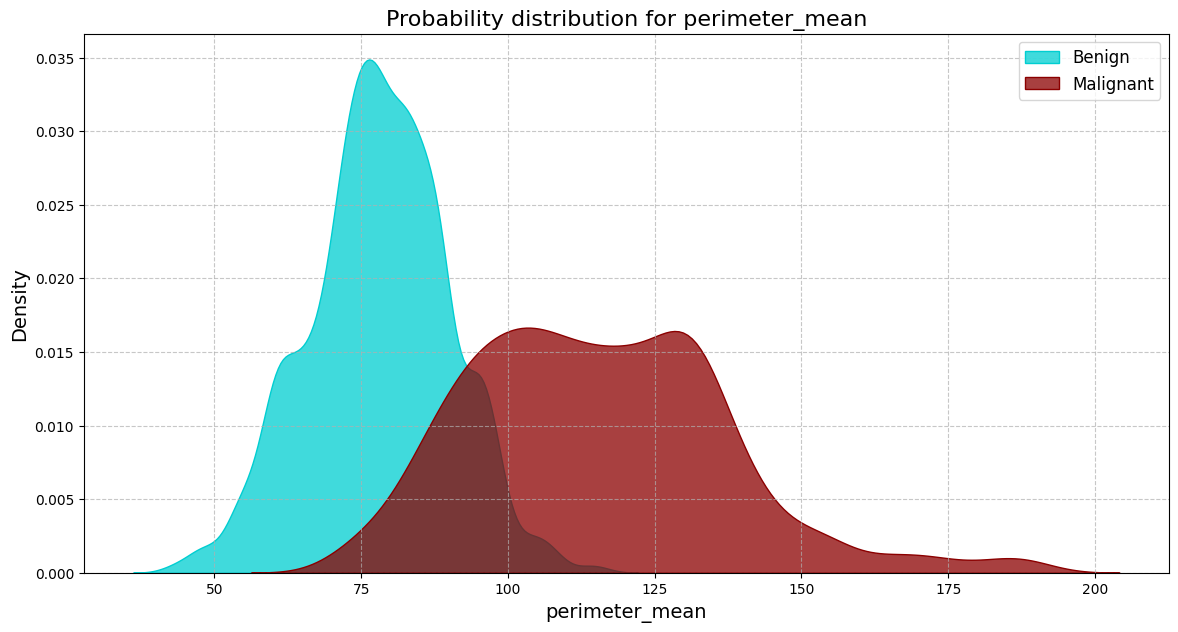

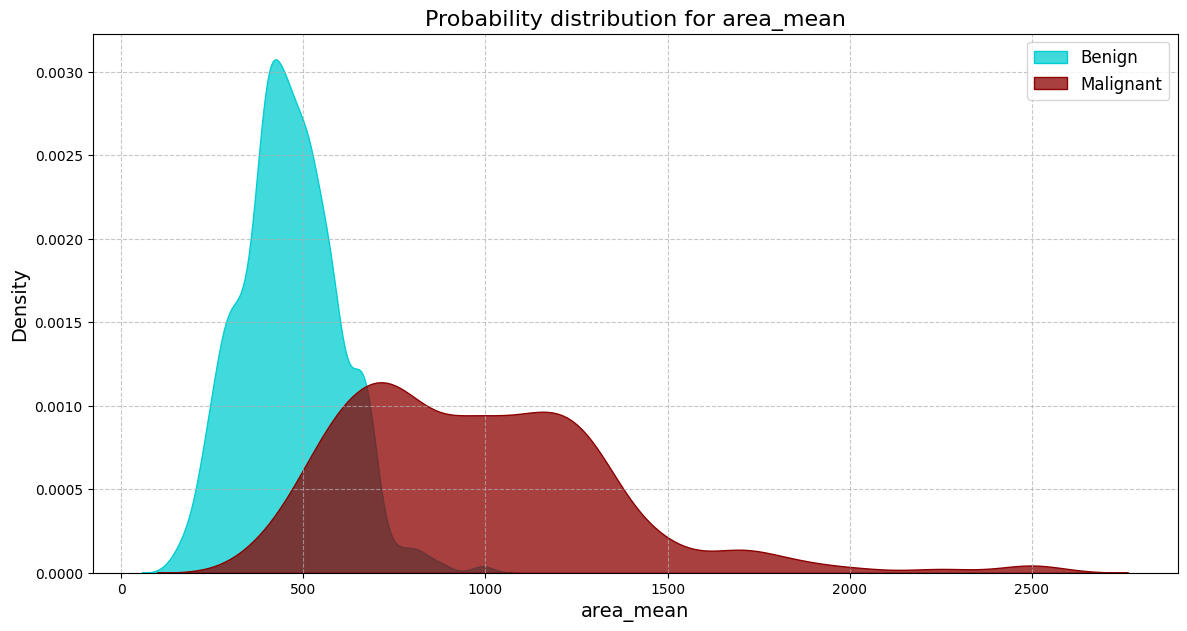

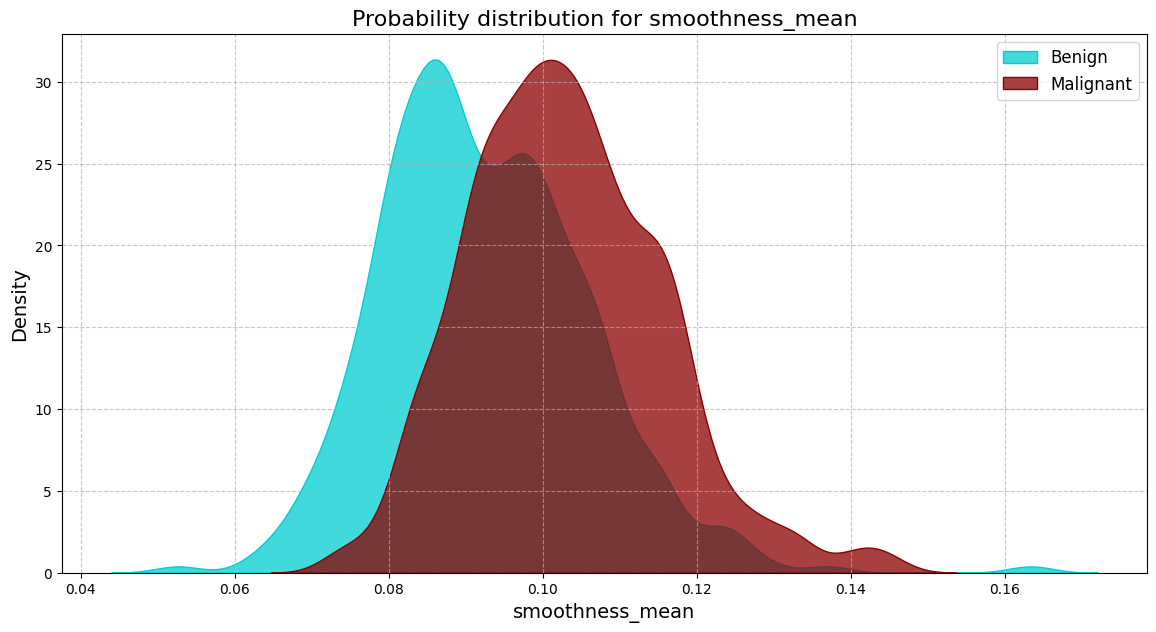

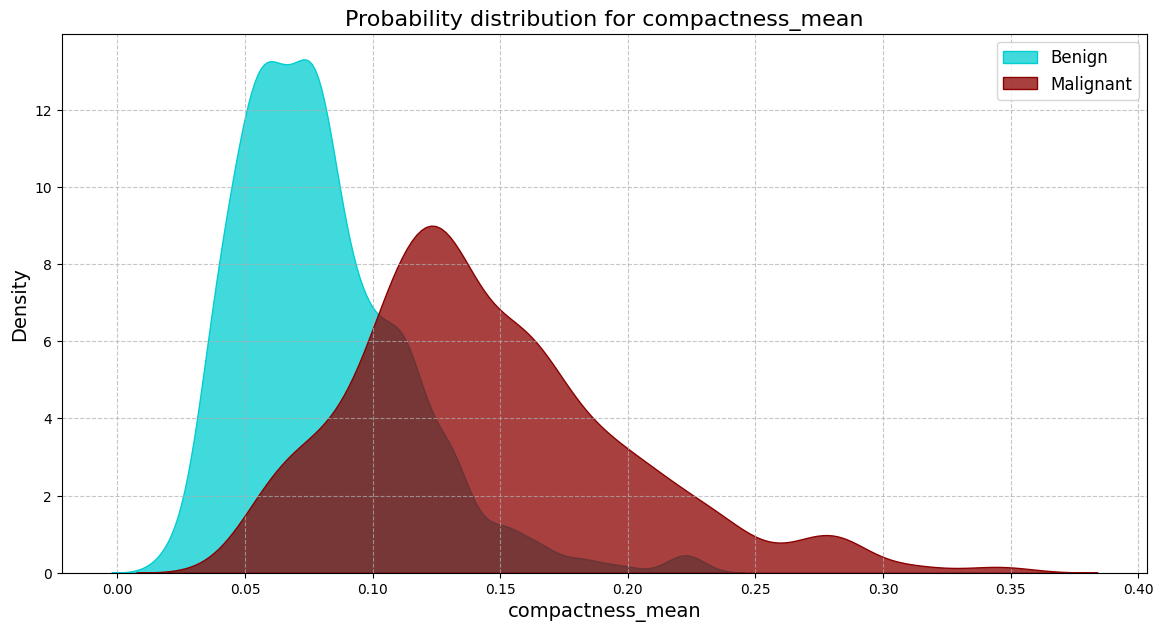

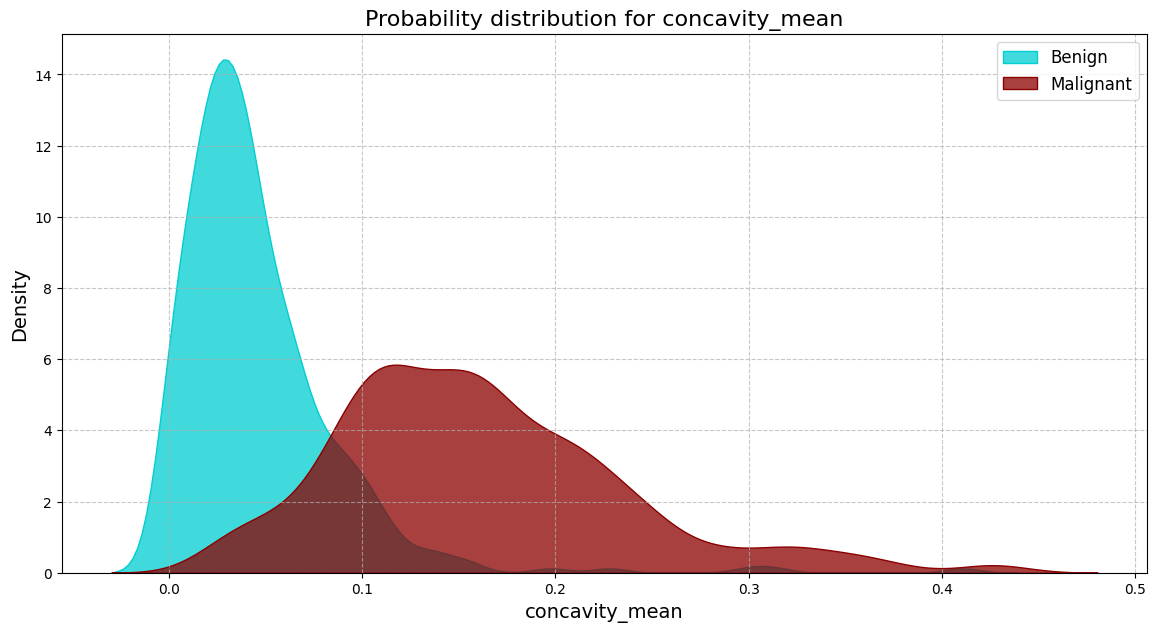

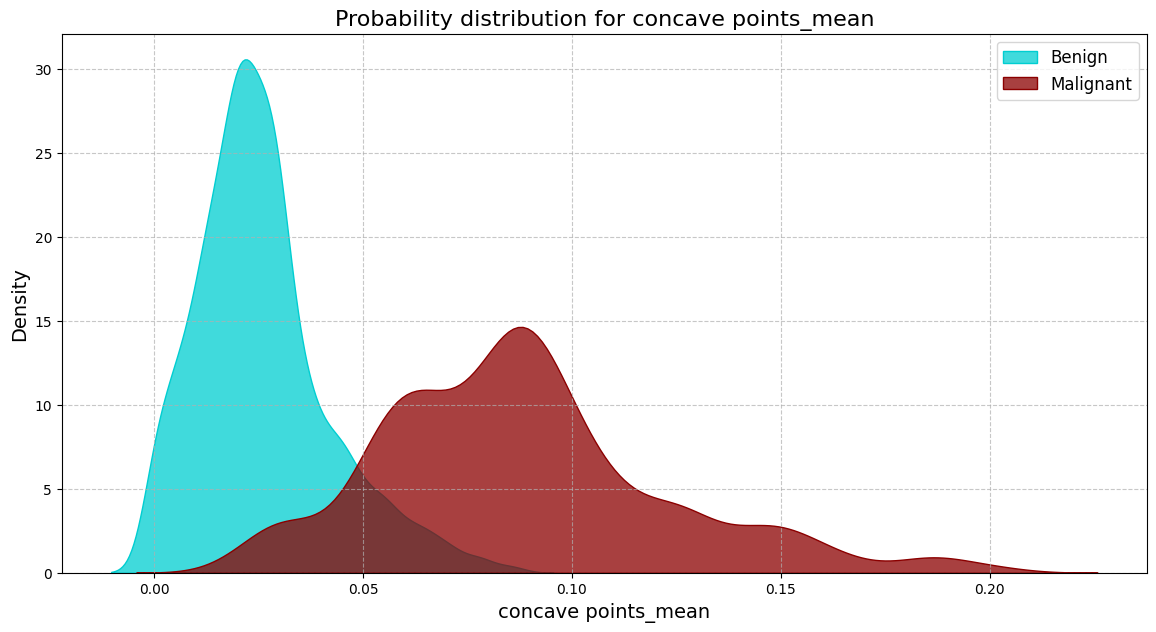

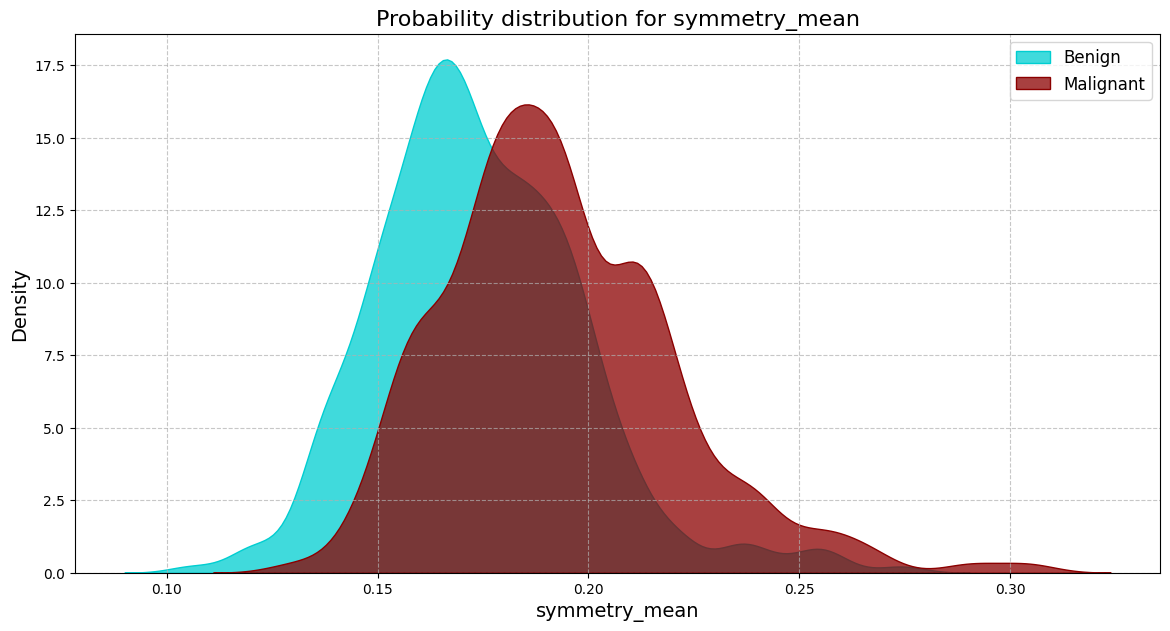

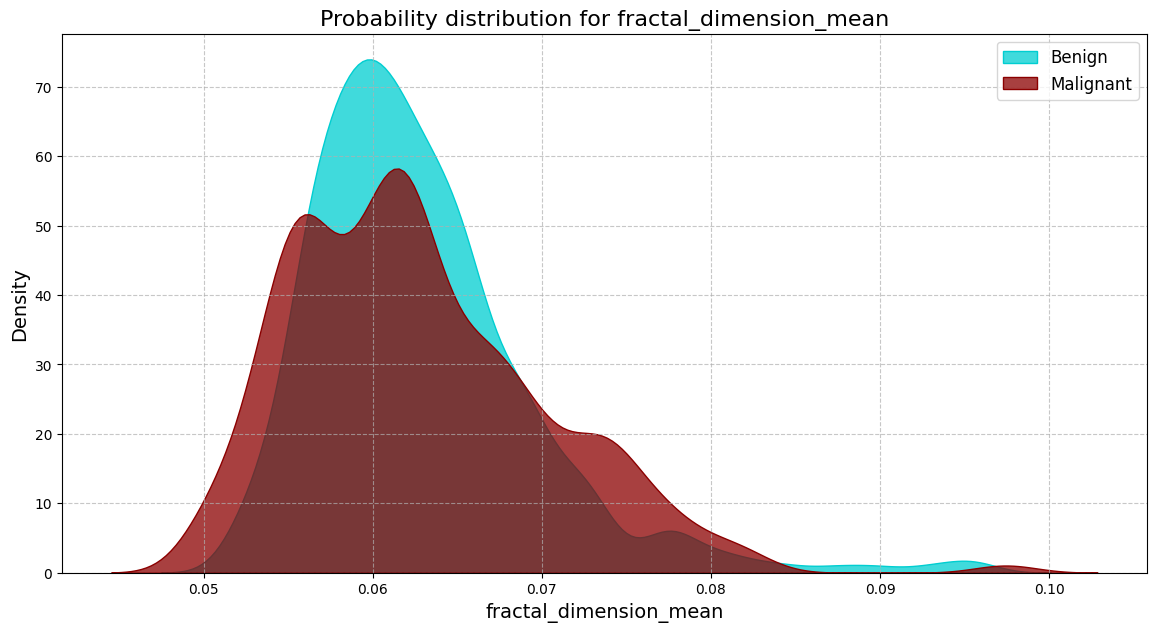

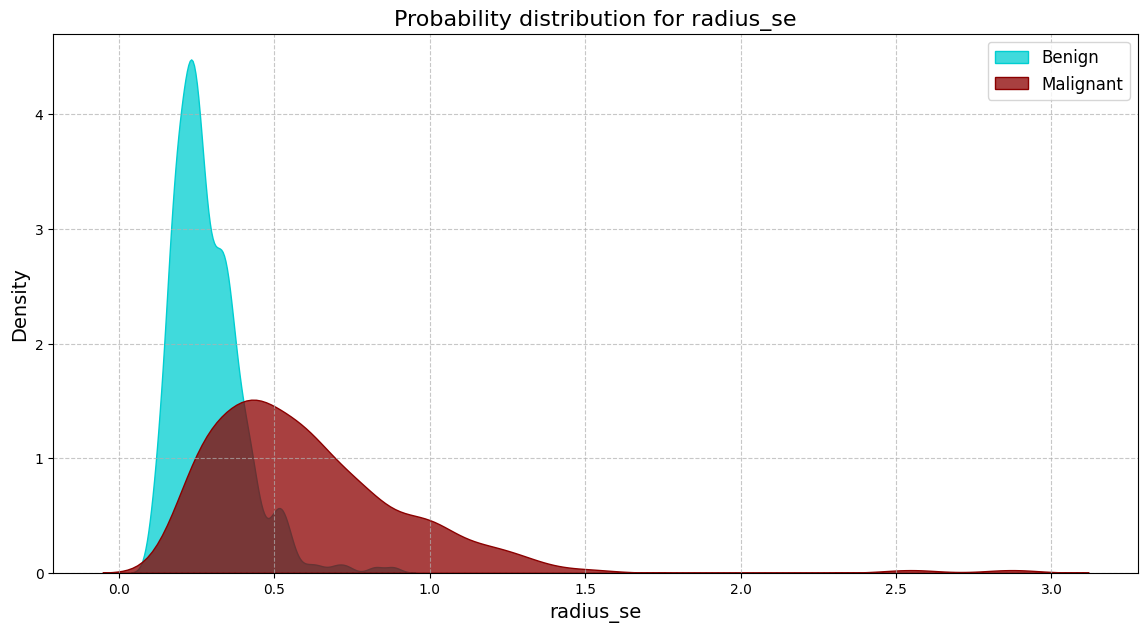

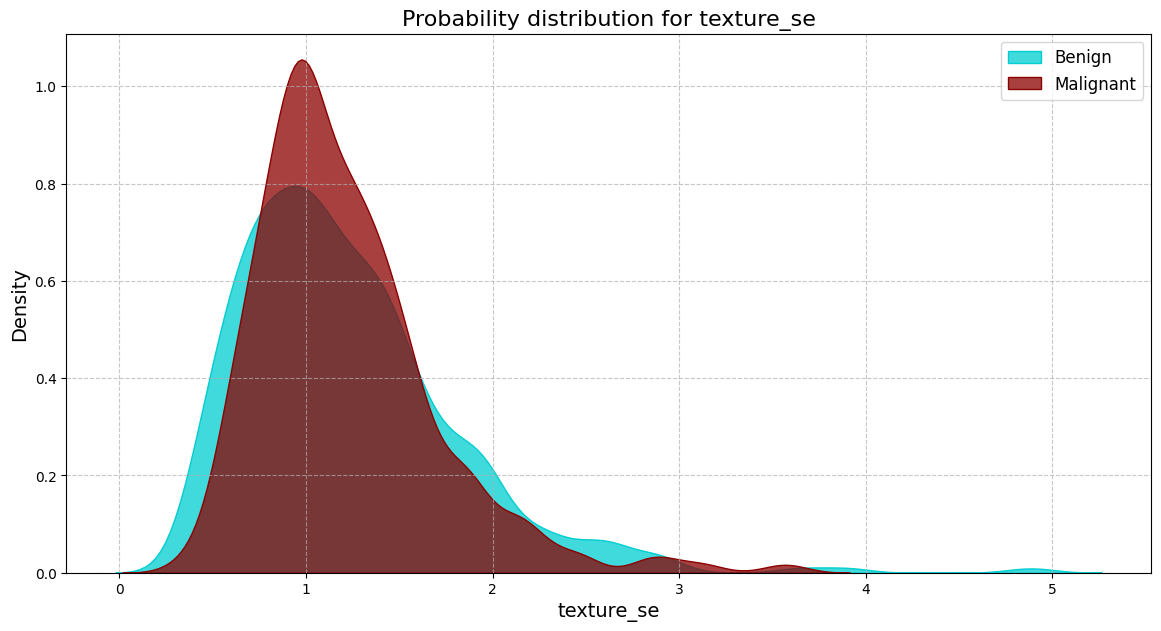

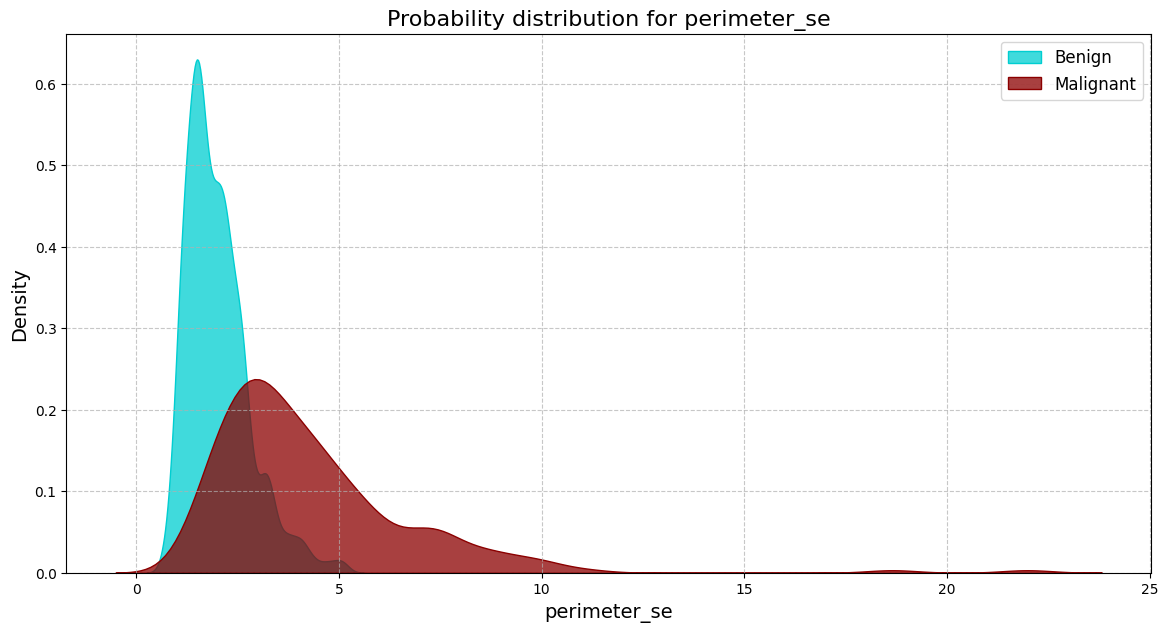

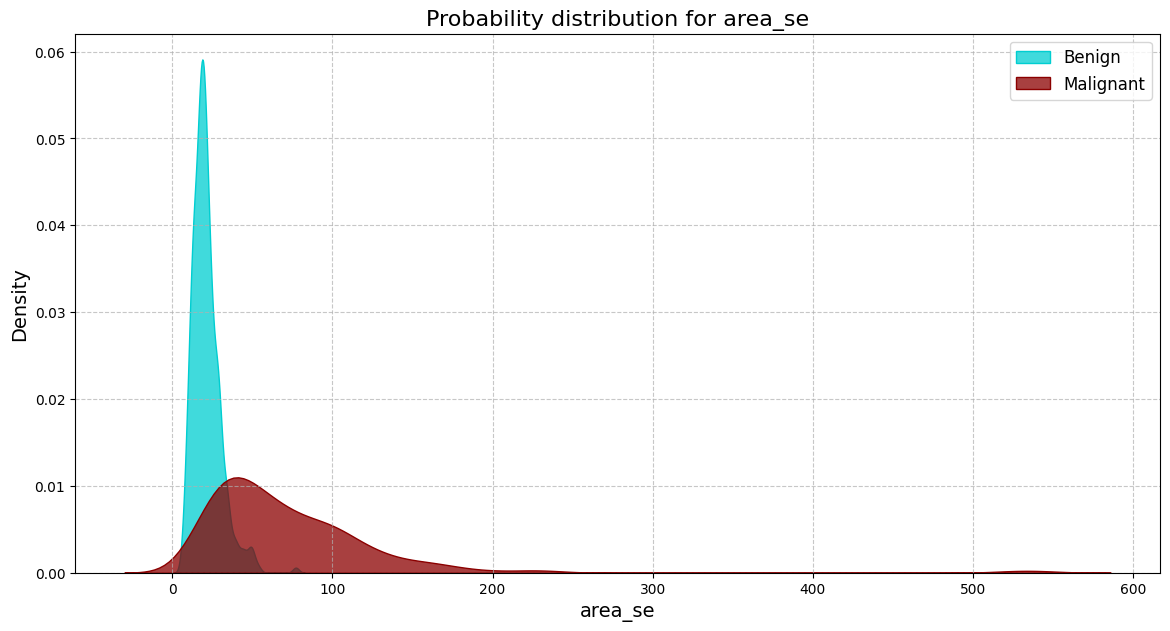

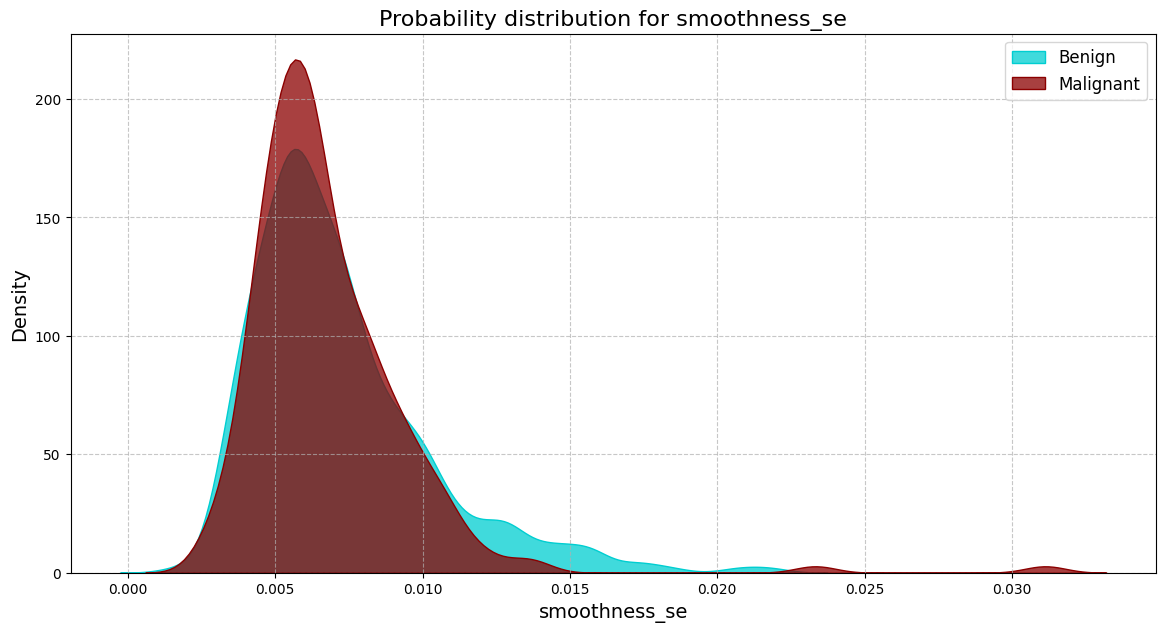

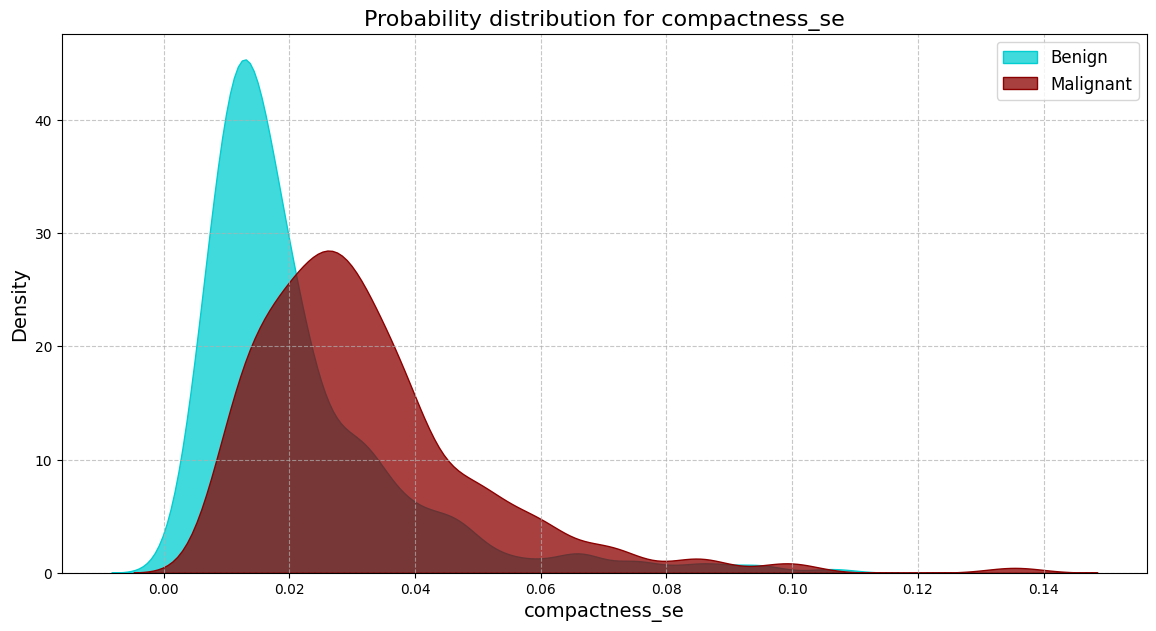

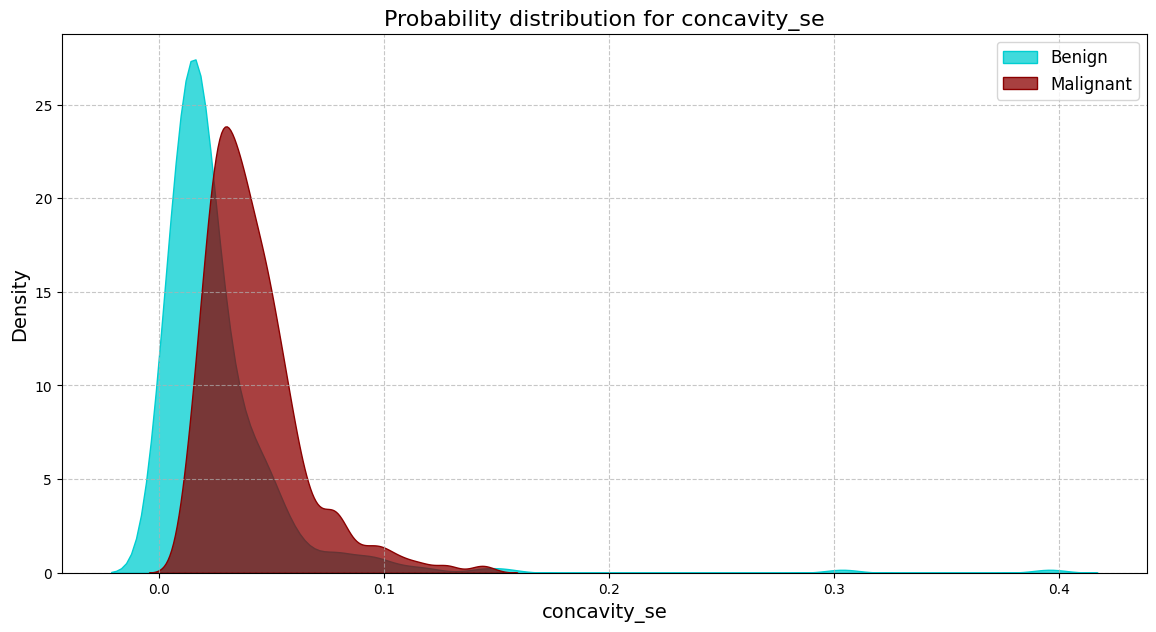

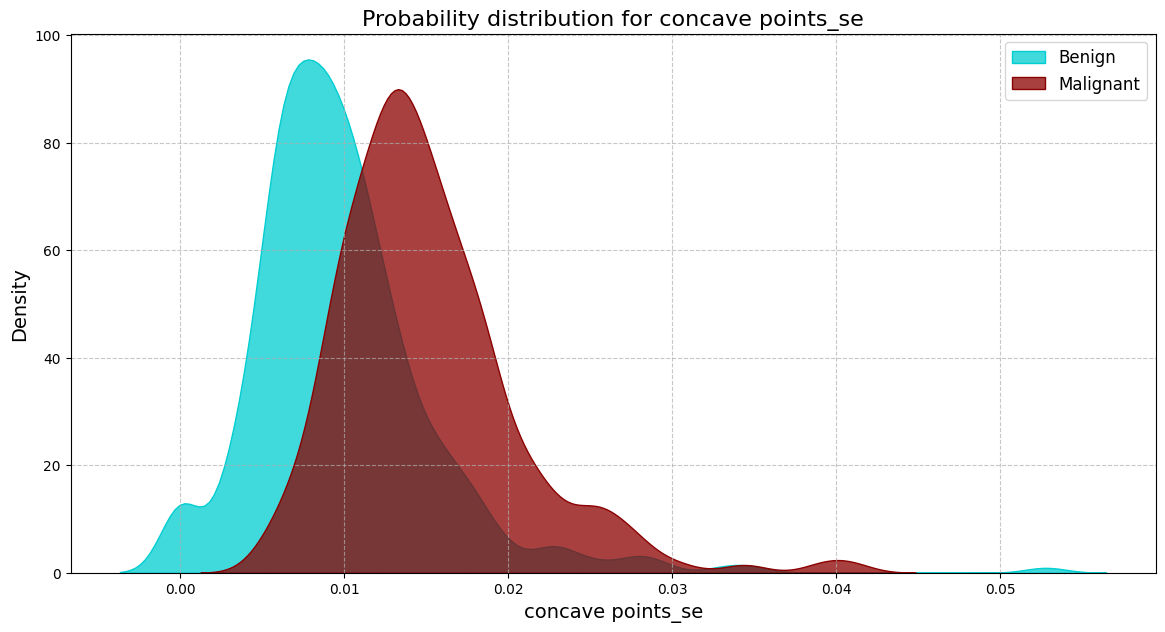

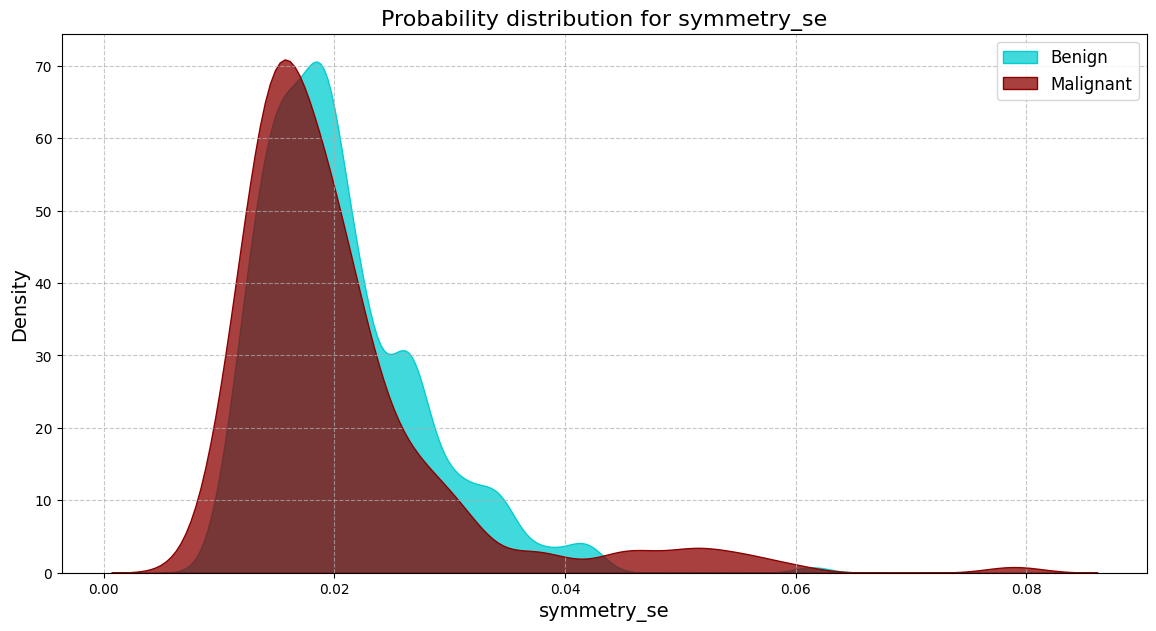

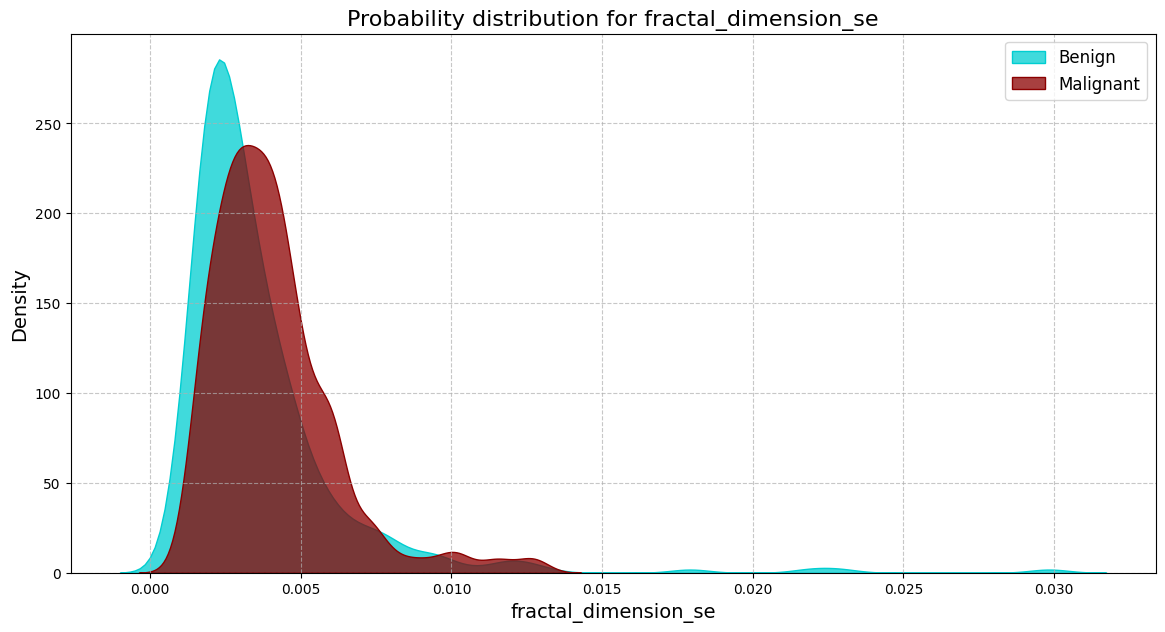

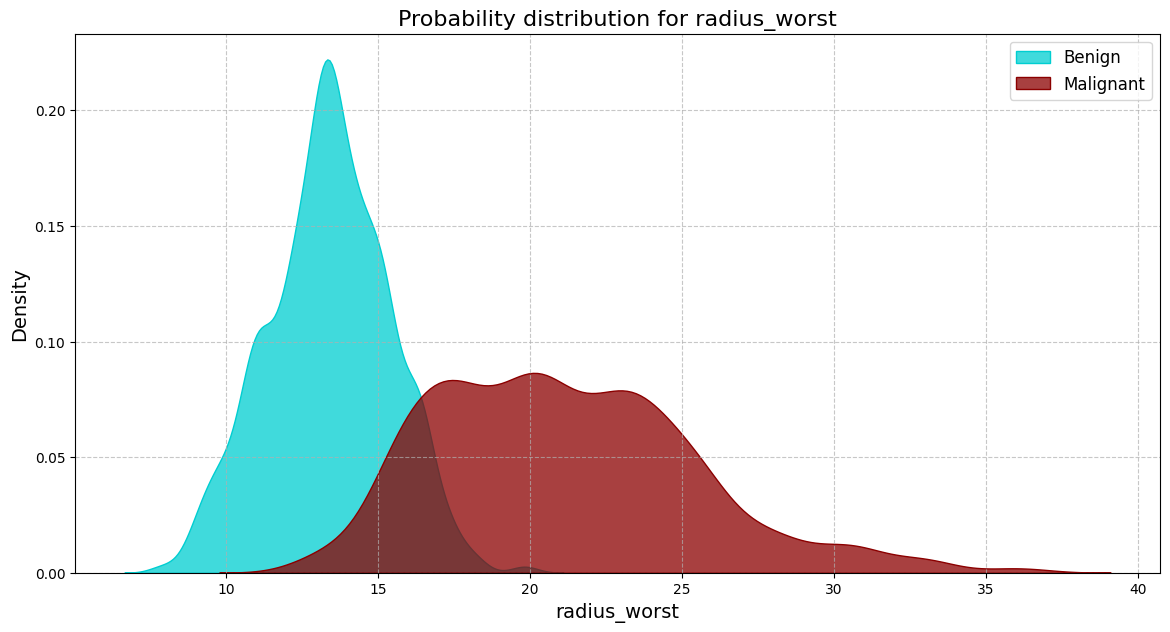

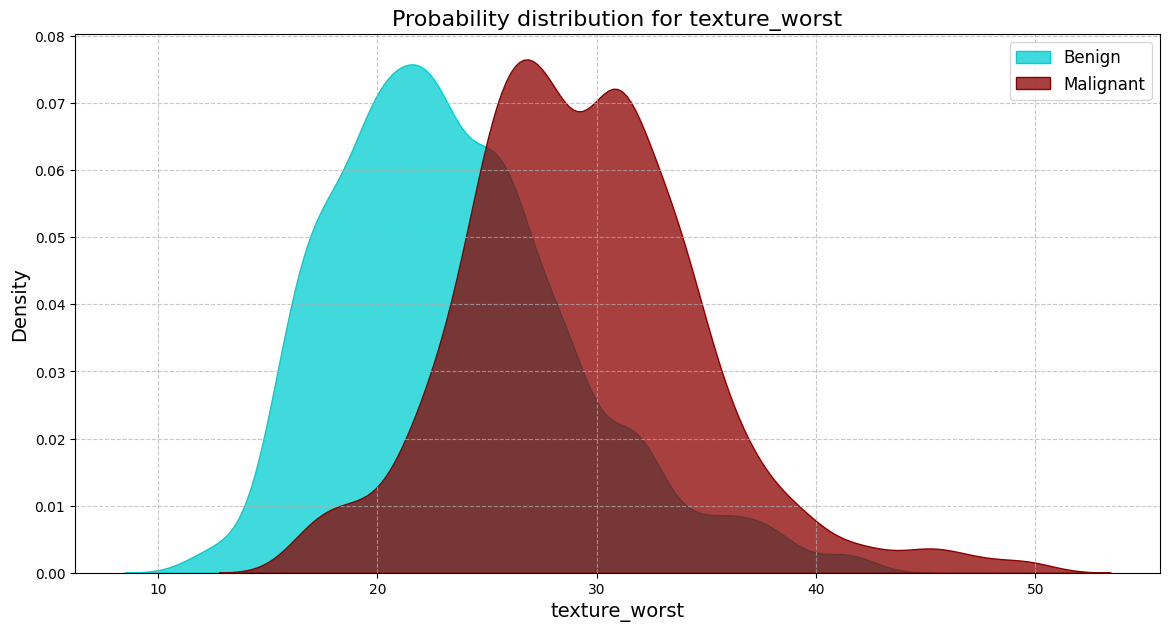

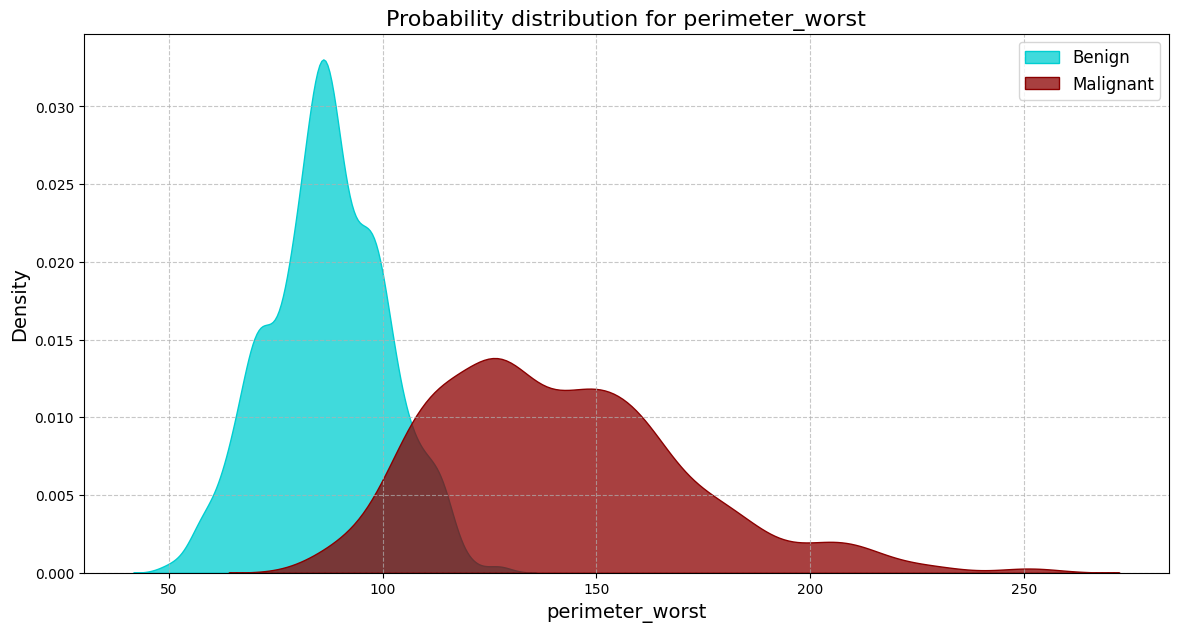

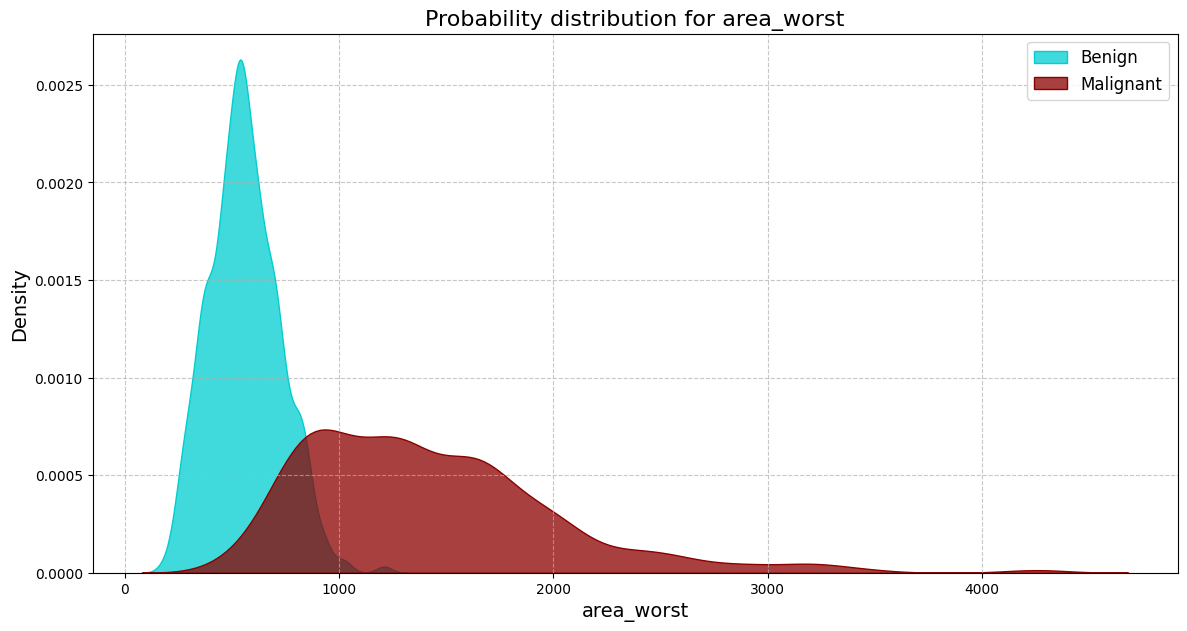

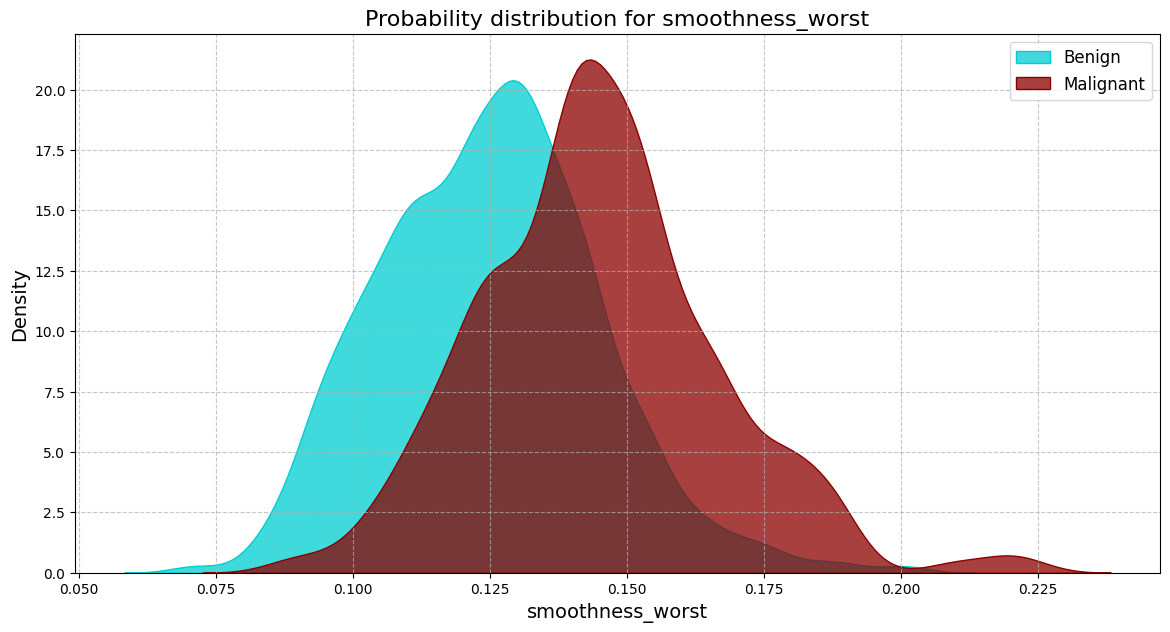

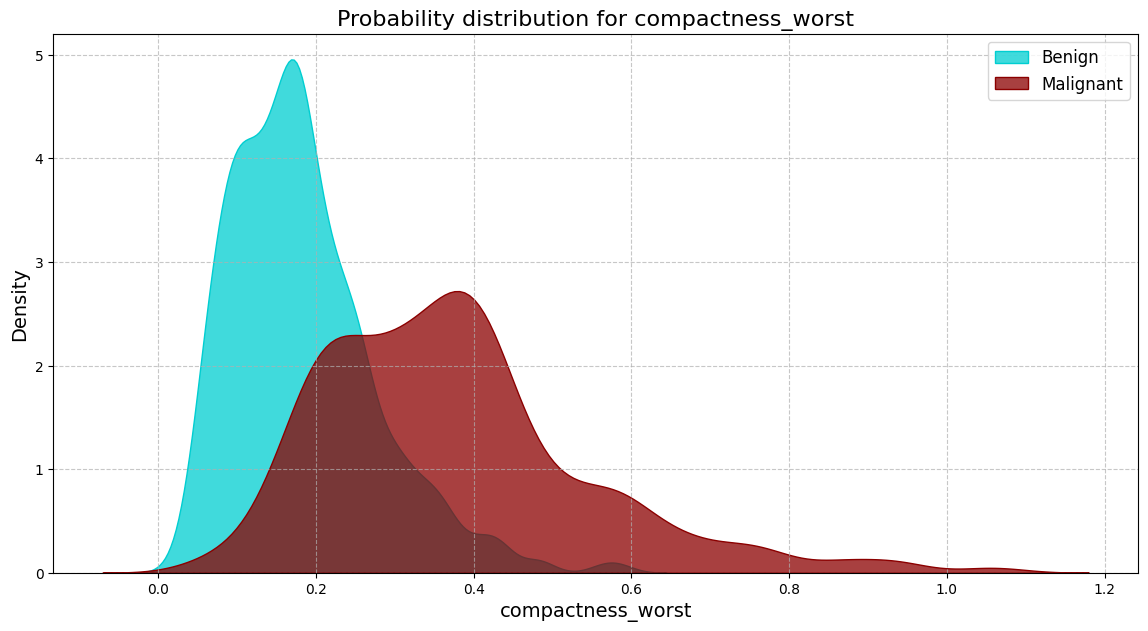

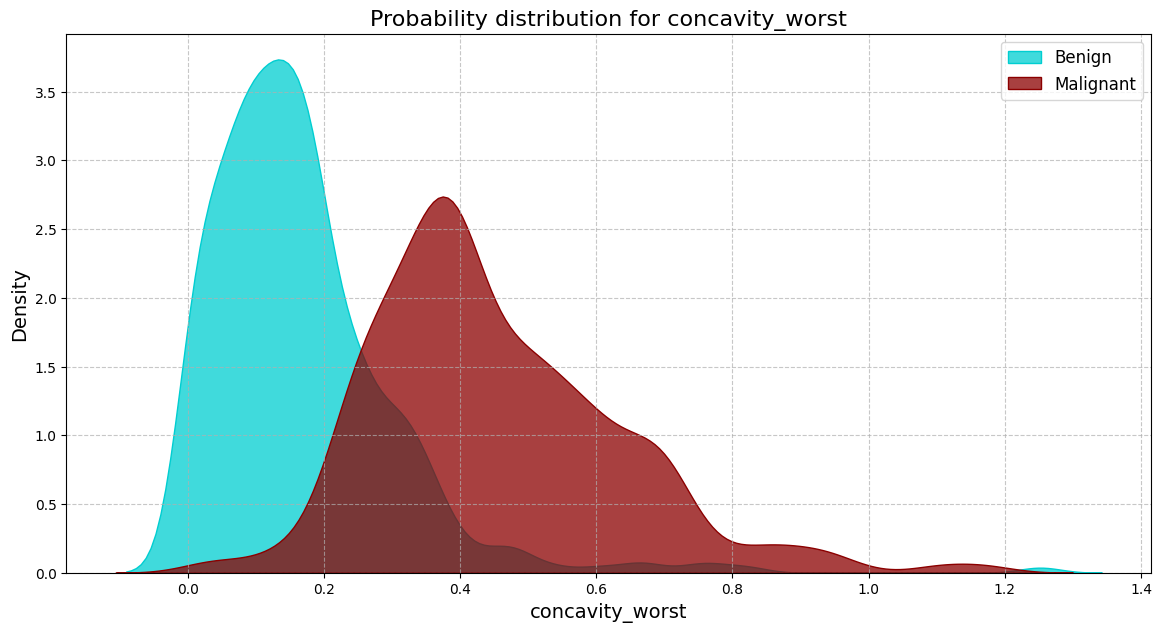

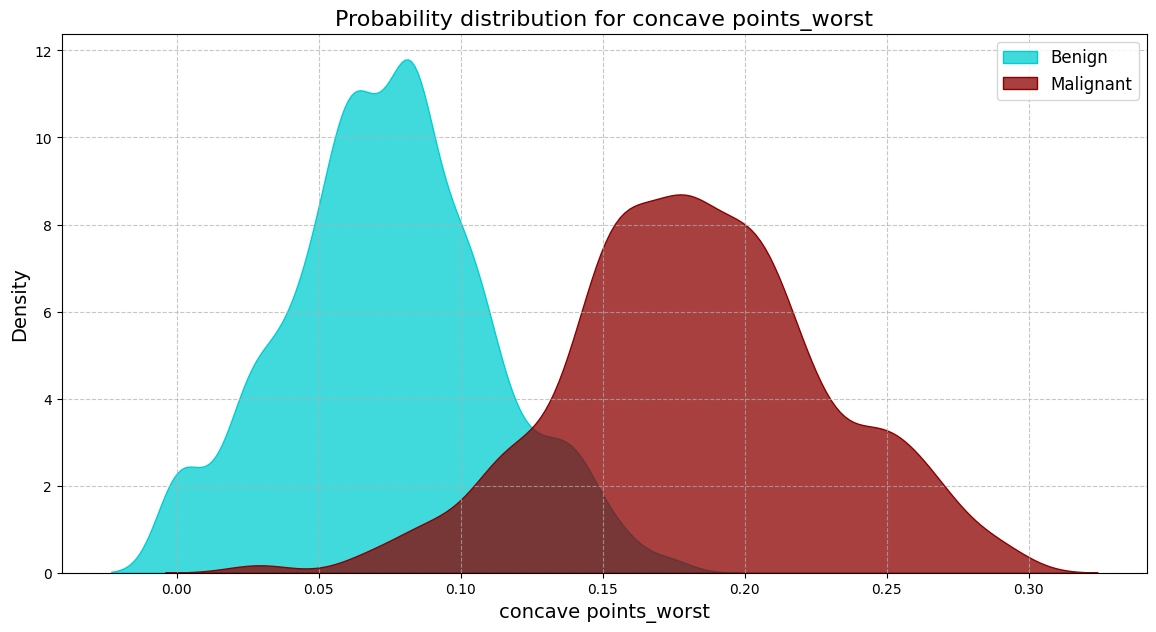

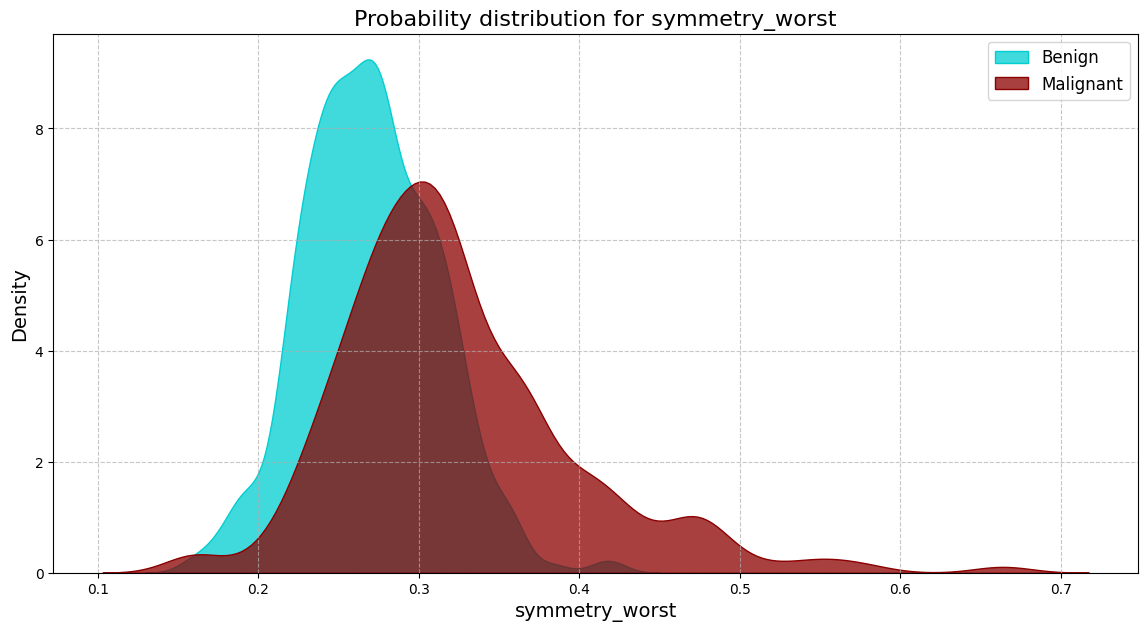

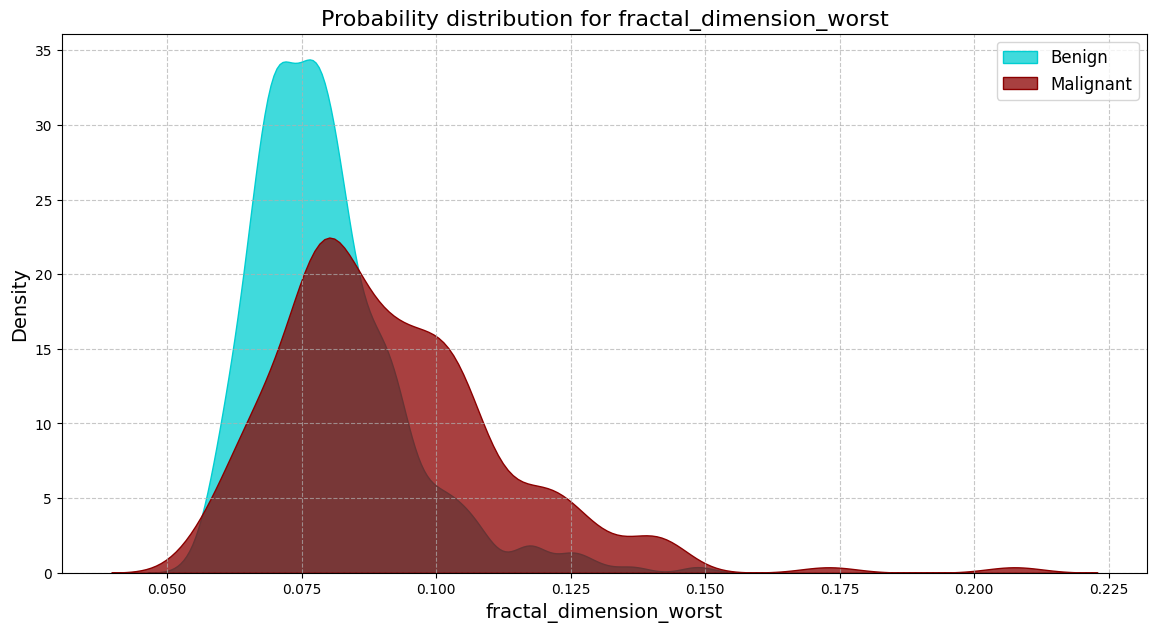